# Target

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
from classes import *
import keras
import matplotlib.pyplot as plt
import numpy as np

In [3]:
shitty_samples = {1,3,4,5,8,11,13,18,19,20,22,23,27,30,32,40,43,52,55,58,60,61,63,67,71,75,76,77,79,80,82,85,86,88,89,91,94,95,97,98}
good_samples = list(set(range(100)) - shitty_samples)
inputs, outputs = load_dataset(
    inputs_map=lambda x: x[:3,:100], outputs_map=lambda x: x[:, :100]
)
coordinate_origin = np.array([23,7])
_, height, width, _ = inputs.shape
coords = coordinates(height,width, coordinate_origin)
repeat_coords = ops.repeat(coords[None,...], 100, axis = 0)
reference_output = outputs[0]
reference_temps =reference_output.reshape((-1,1))
inputs = ops.concatenate((inputs,repeat_coords), axis = -1)
print(f"{inputs.shape=}, {outputs.shape=}")
print(f"{coords.shape=}")
print(f"{reference_output.shape=}")
print(f"{reference_temps.shape=}")

  0%|          | 0/100 [00:00<?, ?it/s]

inputs.shape=torch.Size([100, 100, 16, 5]), outputs.shape=torch.Size([100, 100, 16, 1])
coords.shape=torch.Size([100, 16, 2])
reference_output.shape=torch.Size([100, 16, 1])
reference_temps.shape=torch.Size([1600, 1])


# NeRF-like

In [4]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(2,)),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(1, activation="leaky_relu"),
    ],
    name="NeRF-like",
)

model.summary()

Model: "NeRF-like"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)               │        384 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17,025 (66.50 KB)

 Trainable params: 17,025 (66.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-3), loss="mse", metrics=["mse"]
)
scheduler = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 if epoch < 150 else 3e-4
)
model.fit(
    coords.reshape(-1, 2),
    reference_temps,
    epochs=5000,
    batch_size=100,
    callbacks=[scheduler, CustomTensorboard("logs/nerf")],
    verbose=0,
)

KeyboardInterrupt: 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


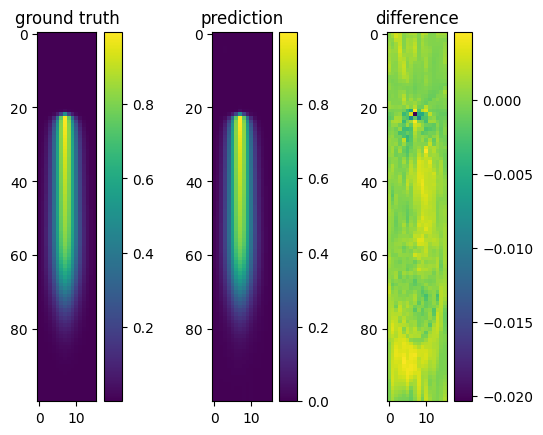

In [9]:
result = model.predict(coords.reshape(-1,2)).reshape(reference_output.shape[:-1])
ref_cpu = reference_output[:,:,0].cpu().numpy()
plt.subplot(1,3,1)
plt.imshow(ref_cpu)
plt.title("ground truth")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(result)
plt.title("prediction")
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(result-ref_cpu)
plt.title("difference")
plt.colorbar()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


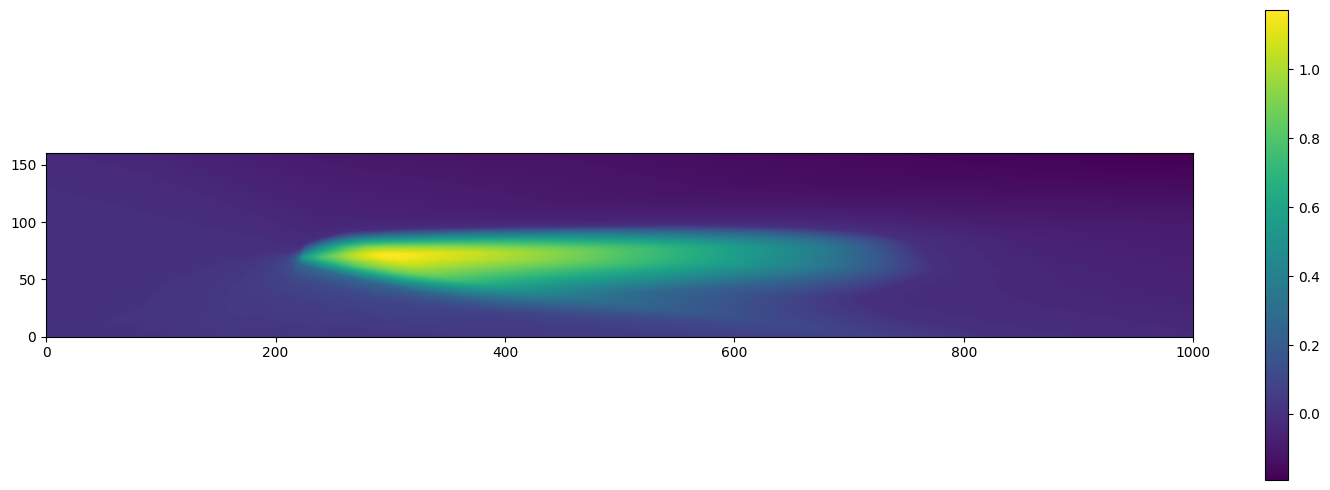

In [40]:
size = (1000,160)
zoom = 1
larger_coords = coordinates(*size, (230,70))
more_resolution = model.predict(larger_coords.reshape(-1,2), batch_size= 10000)
more_resolution = more_resolution.reshape(size)
plt.figure(figsize=(15,5))
plt.imshow(more_resolution.T, extent = (0,size[0]/zoom,0,size[1]/zoom))
plt.colorbar()
plt.tight_layout()
plt.show()

# Coordinate Distortion

### Tomfoolery

In [35]:
def get_coordinates(coords : np.ndarray, image: Image.Image):
    shape = coords.shape
    coords = np.reshape(coords,(-1,2))
    # print(coords.shape)
    transformed = []
    for coord in coords:
        # print(coord.shape)
        if coord[0] < 0 or coord[1] < 0 or coord[0] >= image.width or coord[1] >= image.height:
            transformed.append((0,0,0))
        else:
            transformed.append(image.getpixel(tuple(coord)))
    return np.array(transformed).reshape((*shape[:-1],3))

In [36]:
olol = Image.open("olol.png")
olol.getpixel((-10,0.2))

(228, 7, 20)

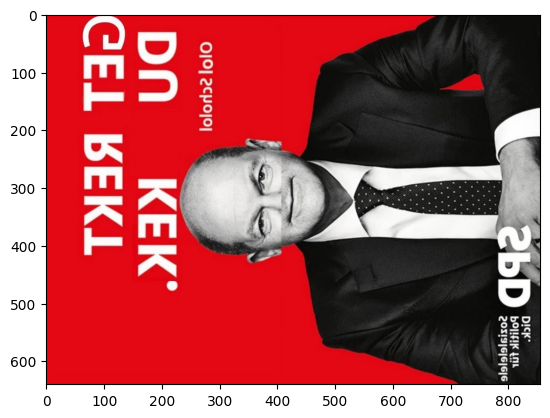

In [37]:
size = olol.size
X,Y = np.meshgrid(np.arange(size[0]),np.arange(size[1]))
coords = np.stack([X,Y]).T
img = get_coordinates(coords, olol)
plt.imshow(img)

In [4]:
def path(a: keras.KerasTensor,b : keras.KerasTensor, random = True):
    # now only in 2D
    dim = 2
    d = b-a
    s = keras.ops.sign(d)
    t = keras.ops.abs(d)
    steps = keras.ops.diag(s)
    moves = []
    for i in range(dim):
        moves.append(keras.ops.repeat(steps[None,i],t[i],axis = 0))
    moves = keras.ops.concatenate(moves,axis = 0)
    if random:
        moves = keras.random.shuffle(moves)
    moves_t = keras.ops.transpose(moves)
    # get indices from 0 to 3, down = 0, left = 1, right = 2, up = 3
    directions = (3*(1+moves_t[0])+moves_t[1])//2
    indices = keras.ops.concatenate((a[None,:],a + keras.ops.cumsum(moves,axis = 0)), axis = 0)
    return indices[:-1], directions

def global_coordinate(distortion: keras.KerasTensor, pump_indices, target, random = True):
    # uses the distortion at the largest x and y coordinates if the target is outside the original distortion
    indices, directions = path(pump_indices,target, random=random)
    flat_local_dist = keras.ops.reshape(distortion,(-1,4,2))
    indices_t = keras.ops.transpose(indices)
    indices_1d = indices_t[0]*distortion.shape[1] + indices_t[1]
    local_distortions = keras.ops.take(flat_local_dist,indices_1d,axis = 0)
    local_distortions = keras.ops.take_along_axis(local_distortions,directions[:,None,None],axis = 1)
    coordinate = keras.ops.sum(local_distortions,axis = 0)
    return keras.ops.reshape(coordinate,(2,))

def convert_to_global(A,pump_indices, random = True):
    height, width = A.shape[:2]
    coordinates = keras.ops.meshgrid(keras.ops.arange(height),keras.ops.arange(width),indexing = "ij")
    coordinates = keras.ops.stack(coordinates,axis = 2)
    coordinates_flat = keras.ops.reshape(coordinates,(-1,2))
    transformed_coordinates = []
    for n, _ in enumerate(coordinates_flat):
        transformed_coordinates.append(global_coordinate(A,pump_indices,coordinates_flat[n], random=random))
    transformed_coordinates = keras.ops.stack(transformed_coordinates,axis = 0)
    return keras.ops.reshape(transformed_coordinates,(height,width,2))

def convert_to_global_2(A,pump_indices):
    # A.shape = (batch, height, width, 2, 2)
    return keras.ops.cumsum(A[...,0,:],axis = -2) + keras.ops.cumsum(A[...,1,:],axis = -3) - pump_indices


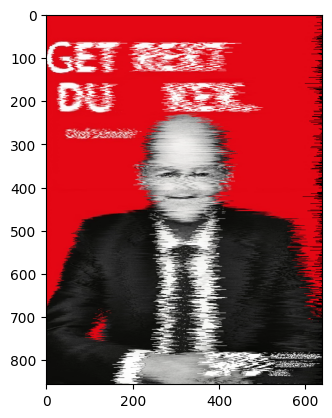

In [184]:
height = olol.size[1]
width = olol.size[0]
no_dist = np.zeros((1,height,width,2,2))
no_dist[...,0,:] = np.array([0,1])
no_dist[...,1,:] = np.array([1,0])
no_dist[...,1,0] = np.random.uniform(0,2,(1,height,width))
no_dist = keras.ops.convert_to_tensor(no_dist)
no_dist = no_dist.reshape((*no_dist.shape[:-2],4))
coordinate_origin = keras.ops.convert_to_tensor((0,0.5),dtype= "float64")
converter = GlobalCoordinate(coordinate_origin)
global_coords = converter(no_dist)[0].cpu().numpy()
img = get_coordinates(global_coords, olol)
plt.imshow(img)

### Actual

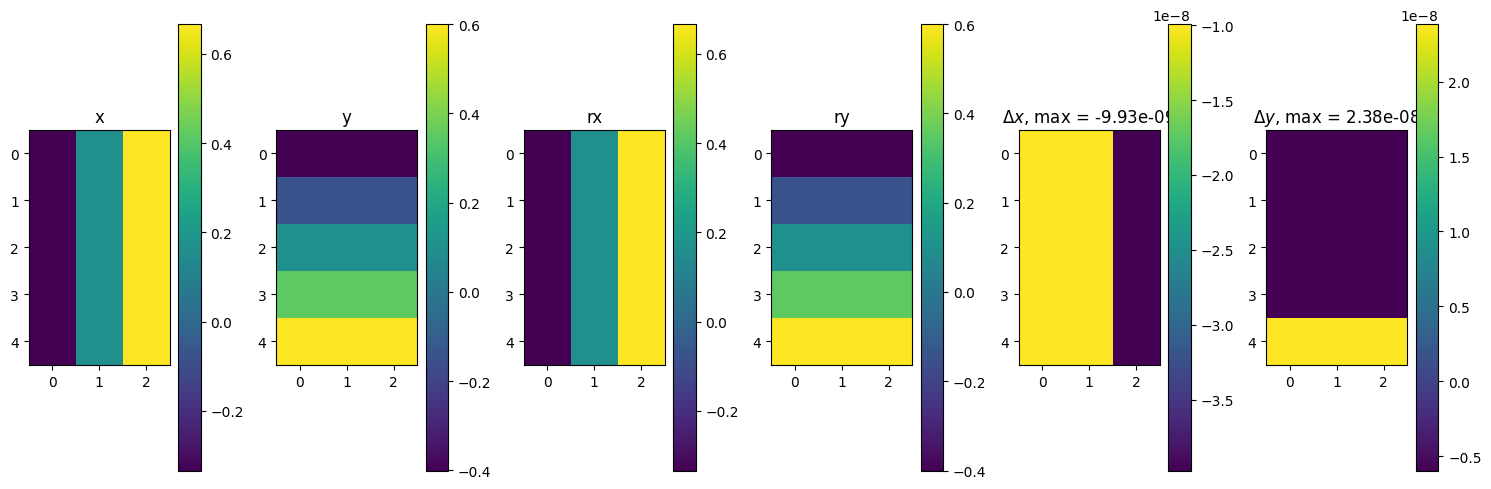

In [23]:
h,w = 5,3
p = (2,1)
coords = coordinates(h,w,p)
coords_cpu = coords.cpu().numpy()
dist = dists_from_coords(coords).reshape(1,h,w,4)
plt.figure(figsize=(15,5))
plt.subplot(1,6,1)
plt.imshow(coords_cpu[:,:,1])
plt.title("x")
plt.colorbar()
plt.subplot(1,6,2)
plt.imshow(coords_cpu[:,:,0])
plt.title("y")
plt.colorbar()
result = GlobalCoordinate((p[0]/h,p[1]/w))(dist)
result_cpu = result.cpu().detach().numpy()
plt.subplot(1,6,3)
plt.imshow(result_cpu[0,:,:,1])
plt.title("rx")
plt.colorbar()
plt.subplot(1,6,4)
plt.imshow(result_cpu[0,:,:,0])
plt.title("ry")
plt.colorbar()
plt.subplot(1,6,5)
deltax = coords_cpu[...,1] - result_cpu[0,...,1]
plt.imshow(deltax)
plt.title(f"$\Delta x$, max = {deltax.max():.2e}")
plt.colorbar()
plt.subplot(1,6,6)
deltay = coords_cpu[...,0] - result_cpu[0,...,0]
plt.imshow(deltay)
plt.title(f"$\Delta y$, max = {deltay.max():.2e}")
plt.colorbar()
plt.tight_layout()
plt.show()

## Distortion Network

In [99]:
_, height, width, _ = inputs.shape
edge_size = 1
coords = coordinates(height, width, coordinate_origin)
distortions = dists_from_coords(coords)
distortions = distortions.reshape(*distortions.shape[:-2], 4)
distortions.shape
flipped_distortions = keras.ops.copy(distortions)
flipped_distortions[ :, :, 0] *= -1
flipped_distortions[ :, :, 2] *= -1
train_outputs = keras.ops.stack([distortions,flipped_distortions])[:,edge_size:-edge_size,edge_size:-edge_size,:]
train_outputs.shape

torch.Size([2, 98, 14, 4])

In [100]:
gradient = inputs[0]
flipped_gradient = keras.ops.flip(gradient,axis = -3)
gradient.shape
train_inputs = keras.ops.stack([gradient,flipped_gradient])
train_inputs.shape

torch.Size([2, 100, 16, 5])

In [5]:
import warnings
# warnings.simplefilter("always")
dist_model = keras.Sequential(
    [
        keras.layers.Input(shape=(100,16,5)),
        # keras.layers.Conv2D(4,3,activation="relu",padding="same"),
        # keras.layers.Conv2D(16,3,activation="tanh",padding="valid"),
        keras.layers.Conv2D(4,3,activation=None, padding ="valid"),
        Rotation(),
    ],
    name = "Distortion Model"
)
dist_model.summary()

Model: "Distortion Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 14, 4)         │        184 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rotation (Rotation)             │ (None, 98, 14, 4)         │          1 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 185 (740.00 B)

 Trainable params: 185 (740.00 B)

 Non-trainable params: 0 (0.00 B)

In [102]:
import logging

logging.basicConfig(level=logging.DEBUG)
dist_model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4), loss="mse")


scheduler = keras.callbacks.LearningRateScheduler(

    lambda epoch: 6e-4 if epoch < 15000 else (3e-4 if epoch < 20000 else 1e-4)
)


dist_model.fit(
    train_inputs,
    train_outputs,

    batch_size=2,
    epochs=30000,
    callbacks=[scheduler, CustomTensorboard("logs/dist")],
    verbose=0,
)

In [103]:
dist_model.save("dist_model.keras")

In [26]:
dist_model = keras.models.load_model("dist_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001F8B32E1AD0>
DEBUG:matplotlib.colorbar:colorbar update normal <matplotlib.colors.Normalize object at 0x000001F804A53650> <matplotlib.colors.Normalize object at 0x000001F804A53650>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001F8048A5B10>
DEBUG:matplotlib.colorbar:colorbar update normal <matplotlib.colors.Normalize object at 0x000001F804A53650> <matplotlib.colors.Normalize object at 0x000001F804A53650>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001F8048A5B10>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001F808DA2CD0>


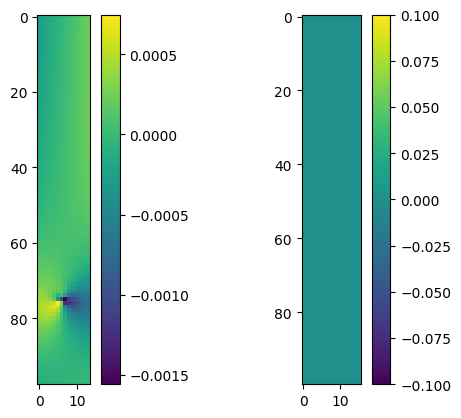

In [105]:
res = dist_model.predict(flipped_gradient[None,...])[0]
dc = distortions.cpu().numpy()
direction = 1
plt.subplot(1,2,1)
plt.imshow(res[...,direction])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(dc[...,direction])
plt.colorbar()

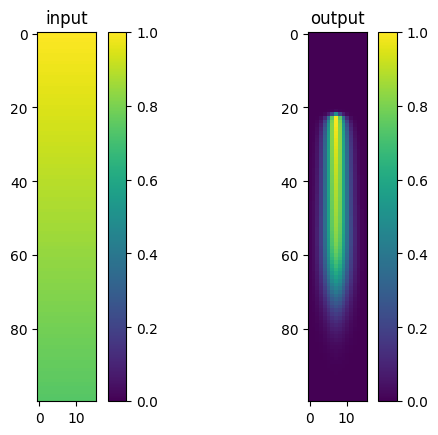

In [74]:
index = 0
plt.subplot(1,2,1)
plt.title("input")
plt.imshow(inputs[index,...,0].cpu().numpy(),vmin= 0,vmax = 1)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("output")
plt.imshow(outputs[index,...,0].cpu().numpy(),vmin= 0,vmax = 1)
plt.colorbar()

In [37]:
model.trainable = True

Model: "Complete Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Local to Global (Sequential)    │ (None, 98, 14, 2)         │        187 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Pretrained Model (ApplyToImage) │ (None, 98, 14, 1)         │     17,025 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17,212 (67.23 KB)

 Trainable params: 17,212 (67.23 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


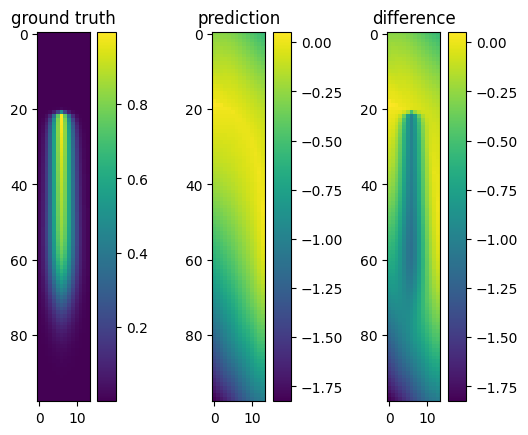

In [6]:
height, width = 100, 16
edge_size = 1
shape = keras.ops.convert_to_tensor([height, width])
pump_location = keras.ops.convert_to_tensor([23, 7], dtype="float64") - edge_size
origin = pump_location/shape

# dist_model = keras.Sequential(
#     [
#         keras.layers.Input(shape=(100, 16, 5)),
#         keras.layers.Conv2D(
#             4,
#             3,
#             activation=None,
#             padding="valid",
#             # kernel_initializer=keras.initializers.RandomUniform(0,0.005),
#             # bias_initializer=keras.initializers.Zeros(),
#         ),
#         # Rotation(),
#     ],
#     name="Distortion Model",
# )
# dist_model = keras.models.load_model("dist_model.keras")





local_to_global = keras.Sequential(
    [
        keras.layers.Input(shape=(100, 16, 5)),
        dist_model,
        GlobalCoordinate(origin,oob_weight = 1, name = "Global Coordinate"),
    ],
    name="Local to Global",
)

# dist_model.trainable = False
# local_to_global.trainable = False
complete_model = keras.Sequential(
    [
        keras.layers.Input(shape=(100, 16, 5)),
        local_to_global,
        ApplyToImage(model, name="Pretrained Model"),
    ],
    name="Complete Model",
)
complete_model.summary()
result = complete_model.predict(inputs[:1])
ref_cpu = outputs[0,edge_size:-edge_size,edge_size:-edge_size,0].cpu().numpy()
plt.subplot(1,3,1)
plt.imshow(ref_cpu)
plt.title("ground truth")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(result[0,:,:,0])
plt.title("prediction")
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(result[0,:,:,0]-ref_cpu)
plt.title("difference")
plt.colorbar()
plt.show()

In [7]:
complete_model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4, weight_decay=0.3), loss="mse")
complete_model.fit(
    inputs[good_samples],
    outputs[good_samples, edge_size:-edge_size, edge_size:-edge_size],
    epochs=30000,
    batch_size=30,
    shuffle = True,
    callbacks=[
        CustomTensorboard("logs/complete"),
        SaveOutputsCallback(inputs[:1]),
    ],
    verbose=0,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


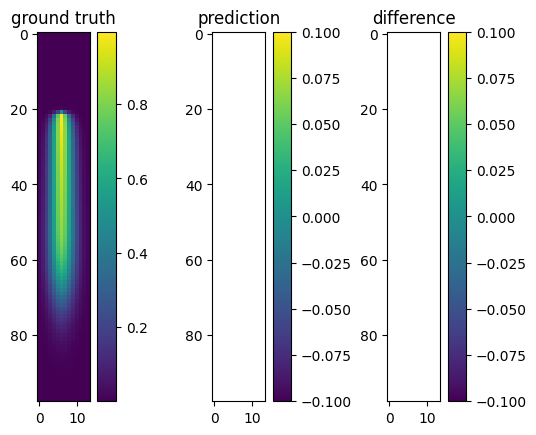

In [110]:
result = complete_model.predict(inputs[:1])
ref_cpu = outputs[0,edge_size:-edge_size,edge_size:-edge_size,0].cpu().numpy()
plt.subplot(1,3,1)
plt.imshow(ref_cpu)
plt.title("ground truth")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(result[0,:,:,0])
plt.title("prediction")
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(result[0,:,:,0]-ref_cpu)
plt.title("difference")
plt.colorbar()
plt.show()

40

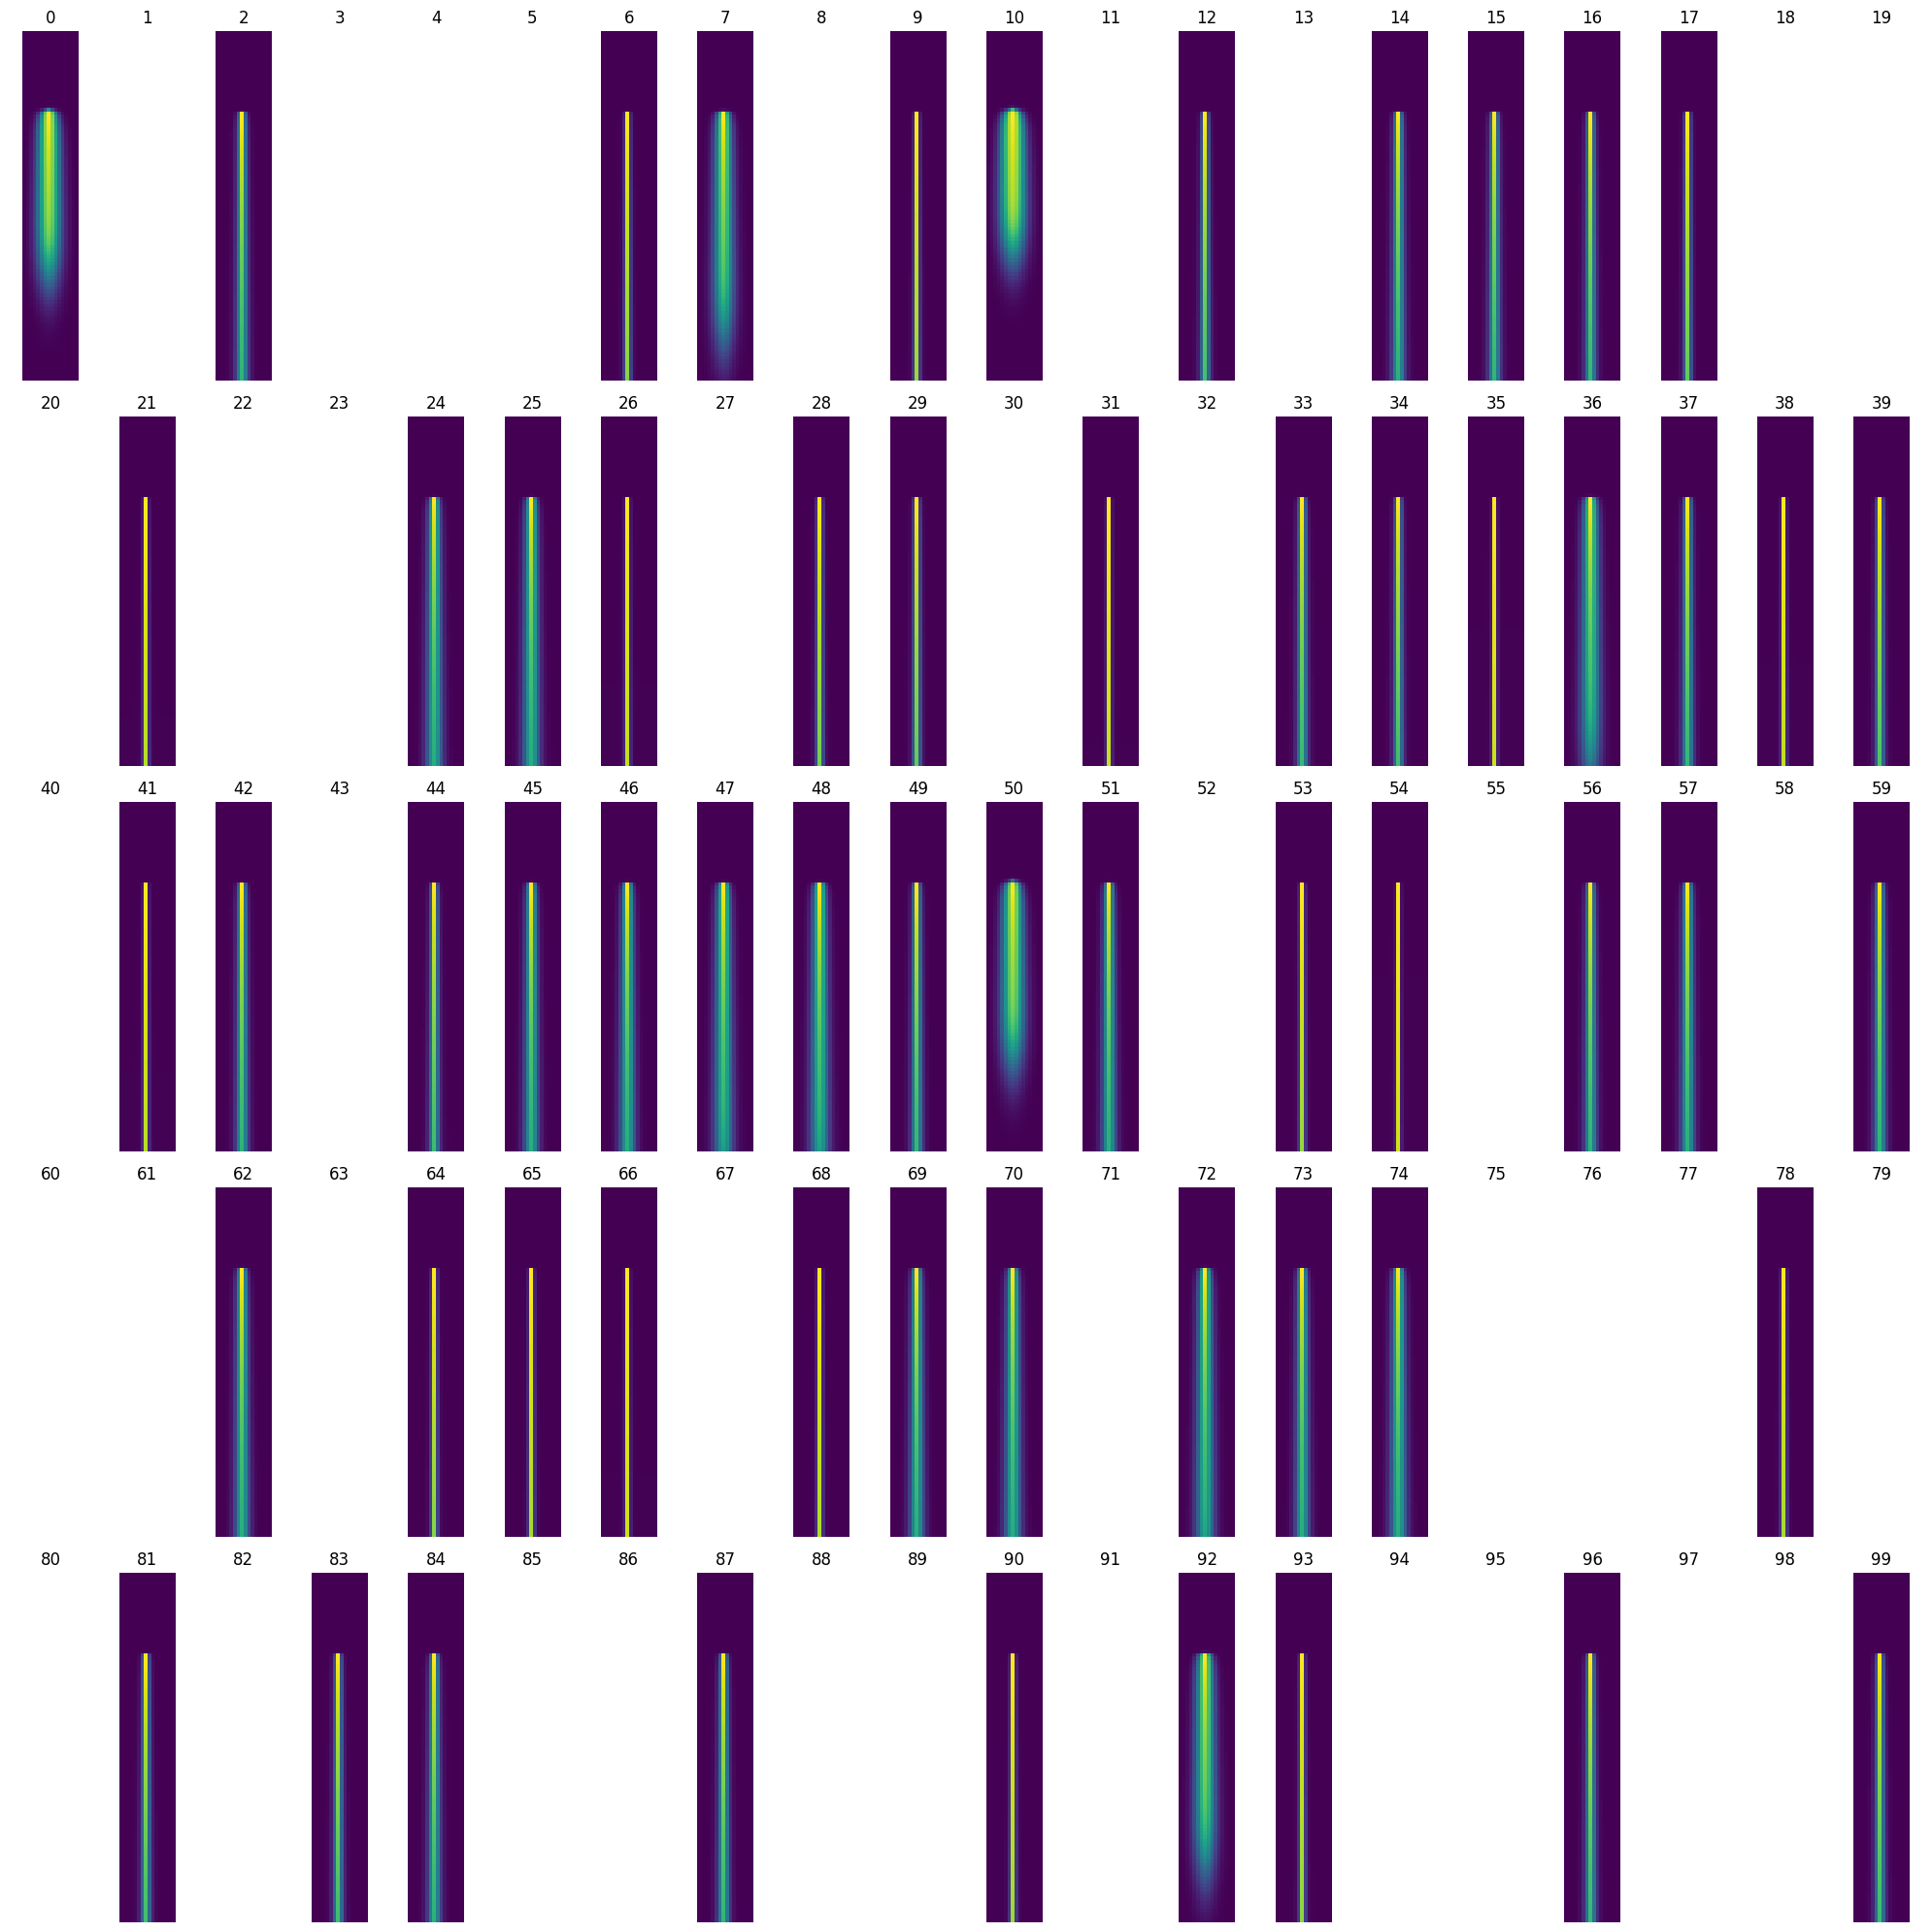

In [100]:
plt.figure(figsize = (20,20))
for i in range(100):
    plt.subplot(5,20,i+1)
    plt.axis("off")
    plt.title(f"{i}")
    if i not in shitty_samples:
        plt.imshow(outputs[i,...,0].cpu().numpy())
plt.tight_layout()
plt.show()

In [104]:
inputs[].shape

torch.Size([40, 100, 16, 2])